# ⚒️ Intervention of ResNet MNIST.

In [19]:
from imports import *
from transformers import ResNetForImageClassification, ResNetConfig


In [20]:
# resnet = ResNetForImageClassification(ResNetConfig(num_labels=10))
resnet = ResNetForImageClassification.from_pretrained('resnet_pvr_model')
resnet.config

ResNetConfig {
  "_name_or_path": "resnet_pvr_model",
  "architectures": [
    "ResNetForImageClassification"
  ],
  "depths": [
    3,
    4,
    6,
    3
  ],
  "downsample_in_bottleneck": false,
  "downsample_in_first_stage": false,
  "embedding_size": 64,
  "hidden_act": "relu",
  "hidden_sizes": [
    256,
    512,
    1024,
    2048
  ],
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_type": "bottleneck",
  "model_type": "resnet",
  "num_channels": 3,
  "out_features": [
    "stage4"
  ],
  "out_indices": [
    4
  ],
  "pooler_shape": [
    1,
    1,
    14,
    14
  ],
  "stage_names": [
    "stem",
    

In [21]:
resnet

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [22]:
image = Image.open('pvr_mnist_dataset/images/combined_image_0.png').convert('RGB')

Converted the code:
``` 
# returning un-intervened output without gradients
with torch.inference_mode():
    base_outputs = self.model(base)
```

and also the code 

```
# run intervened forward
counterfactual_outputs = self.model(**base)
set_handlers_to_remove.remove()
```

I removed `(**base)` and converted to just `(base)`

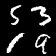

In [25]:
transforms.ToPILImage()(np.array(image))

In [42]:
import pyvene as pv

config = resnet.config

pv_resnet = pv.IntervenableModel({
    "component": "resnet.embedder.pooler.output", 
    "source_representation": torch.zeros(config.pooler_shape, dtype = torch.float32)}, model=resnet)


intervened_outputs = pv_resnet(
    base = torch.tensor(np.array(image), dtype = torch.float32).reshape(1,-1,56,56), 
    unit_locations={"sources->base": [0,5]}
    # unit_locations={"base": [0,1,2,3]}, 
    # subspaces=[0,1,2,3]
    )[0][-1][0]

'''
The unit locations has been defined in such a way that it corresponds to the 
language models having the dimension in the order (batch_size, sequence_length, hidden_size).
Meanwhile, the images have the dimension in the order 
(batch_size, channels, height, width), hence creating an issue.
'''

# I think intervened output gives both the output of the model, i.e. the prediction of counterfactual and also of factual model.

# print("Now finally, the model has ran and this is the intervened output" +str( intervened_outputs))

print(intervened_outputs)
predicted_indices = torch.argmax(intervened_outputs)
class_names = [str(i) for i in range(10)]  # Class names from 0 to 9
# predicted_classes = [class_names[idx] for idx in predicted_indices.cpu().numpy()]
class_names[int(predicted_indices)]



torch.Size([1, 3, 56, 56])
The shape of the embedding is:  torch.Size([1, 64, 14, 14])
The pooled output is tensor([[[[0.2430]],

         [[0.4059]],

         [[0.8159]],

         ...,

         [[1.3420]],

         [[1.9914]],

         [[0.9227]]]])
The logits are: tensor([[-1.1156,  9.2307, -2.5067,  0.1523,  0.2751, -0.5534, -1.8131,  5.7419,
         -1.9340,  1.0866]])
torch.Size([1, 3, 56, 56])
The shape of the embedding is:  torch.Size([1, 64, 14, 14])
The pooled output is tensor([[[[0.2617]],

         [[0.3737]],

         [[0.9720]],

         ...,

         [[1.4029]],

         [[2.1117]],

         [[0.8923]]]])
The logits are: tensor([[-1.0186, 10.0197, -2.7486,  0.0387, -0.2787, -0.0778, -2.0318,  5.2120,
         -1.8844,  1.6402]])
tensor([-1.1156,  9.2307, -2.5067,  0.1523,  0.2751, -0.5534, -1.8131,  5.7419,
        -1.9340,  1.0866])


'1'